# Histopathologic Cancer Detection Using Deep Learning

This notebook addresses the challenge of detecting cancer in histopathologic images using deep learning. We explore the data, build, tune, and evaluate a convolutional neural network (CNN) to classify images as either cancerous or non-cancerous.


## Problem Overview

Histopathologic cancer detection involves classifying tissue images as cancerous or non-cancerous—a crucial step in early diagnosis. In this notebook, we'll tackle the problem using a deep learning approach with a convolutional neural network (CNN). Our process includes exploratory data analysis (EDA), data augmentation to enhance training, and model tuning with regularization and callbacks for better generalization.

In [8]:
# Core system tools
import os
import gc
import time
import warnings
import shutil

# Numerical and data handling
import numpy as np
import pandas as pd
from time import time
# Image processing
import cv2
import tensorflow as tf
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Model building (TensorFlow/Keras API)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPool2D, SpatialDropout2D, BatchNormalization, 
    GlobalAveragePooling2D, Dense, Dropout, LeakyReLU
)
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Metrics and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")


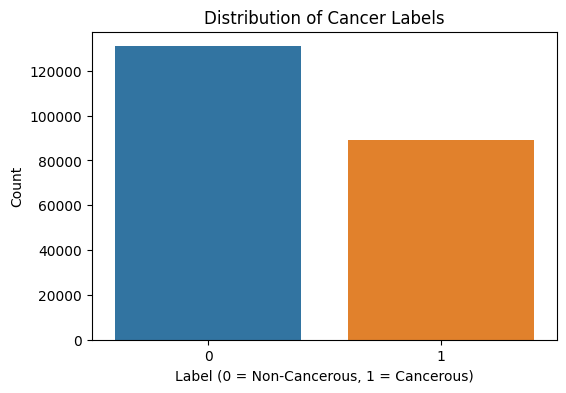

In [9]:
# Load CSV containing training IDs and labels
meta_df = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")
meta_df["file_name"] = meta_df["id"].apply(lambda v: v + ".tif")

# Equalize class representation by sampling
sample_count = 80000
positive_df = meta_df[meta_df["label"] == 1].sample(n=sample_count)
negative_df = meta_df[meta_df["label"] == 0].sample(n=sample_count)
combined_df = pd.concat([positive_df, negative_df], ignore_index=True)

del positive_df, negative_df

# Plot the distribution of the labels in the CSV file
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=meta_df)  # meta_df contains the CSV data
plt.title('Distribution of Cancer Labels')
plt.xlabel('Label (0 = Non-Cancerous, 1 = Cancerous)')
plt.ylabel('Count')
plt.show()

We can see that we have enough samples of both cases and there is not a huge imbalance of one specific label type.

In [10]:
# Split into training and validation sets
train_data, valid_data = train_test_split(
    combined_df, 
    test_size=0.1, 
    stratify=combined_df["label"]
)
train_data.reset_index(drop=True, inplace=True)
valid_data.reset_index(drop=True, inplace=True)

train_data["label"] = train_data["label"].astype(str)
valid_data["label"] = valid_data["label"].astype(str)

num_train = train_data.shape[0]
num_valid = valid_data.shape[0]

print("Training data size: {}.".format(num_train))
print("Validation data size: {}.".format(num_valid))

del combined_df
gc.collect()


Training data size: 144000.
Validation data size: 16000.


2799

In [5]:
# Configure image generator for preprocessing and augmentation
generator_config = {
    "rescale": 1.0 / 255,
    "samplewise_center": True,
    "samplewise_std_normalization": True,
    "horizontal_flip": True,
    "vertical_flip": True
}
data_generator = ImageDataGenerator(**generator_config)

image_dims = (96, 96, 3)
image_source_dir = "/kaggle/input/histopathologic-cancer-detection/train"
batch_count = 512


In [ ]:
# Create generators for training and validation data
train_flow = data_generator.flow_from_dataframe(
    dataframe=train_data,
    directory=image_source_dir,
    x_col="file_name",
    y_col="label",
    has_ext=True,
    target_size=image_dims[:2],
    batch_size=batch_count
)

valid_flow = data_generator.flow_from_dataframe(
    dataframe=valid_data,
    directory=image_source_dir,
    x_col="file_name",
    y_col="label",
    has_ext=True,
    target_size=image_dims[:2],
    batch_size=1,
    shuffle=False
)


## Model Architecture

The architecture uses a series of convolutional layers with batch normalization and LeakyReLU activations, followed by spatial dropout to reduce overfitting. Global average pooling and dense layers are employed to produce the final classification.

#### What We Do:

**Architecture Design:** Build a CNN architecture that extracts features from images using convolutional layers.

**Activation Functions & Regularization:** Use LeakyReLU to mitigate the dying ReLU problem, along with batch normalization and dropout layers.

**Model Rationale:** The architecture is chosen for its balance between depth and complexity, allowing for robust feature extraction while controlling overfitting.

**Hyperparameter Tuning:** Consider callbacks like EarlyStopping and ReduceLROnPlateau to adjust learning rates and halt training when performance stagnates.

In [11]:
model = Sequential()

model.add(Conv2D(32, (5, 5), padding='same', kernel_initializer=HeNormal(), input_shape=image_dims))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(32, (5, 5), padding='same', kernel_initializer=HeNormal()))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D())
model.add(SpatialDropout2D(0.3))

model.add(Conv2D(64, (5, 5), padding='same', kernel_initializer=HeNormal()))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(64, (5, 5), padding='same', kernel_initializer=HeNormal()))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D())
model.add(SpatialDropout2D(0.3))

model.add(Conv2D(128, (5, 5), padding='same', kernel_initializer=HeNormal()))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(128, (5, 5), padding='same', kernel_initializer=HeNormal()))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D())
model.add(SpatialDropout2D(0.3))

model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dense(256))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [21]:
# Define callbacks
lr_schedule = ReduceLROnPlateau(monitor="val_acc", factor=0.5, patience=1, min_lr=1e-5)
early_stopping = EarlyStopping(monitor="val_acc", patience=3, verbose=1, mode= 'max')

start_time = time()

print("Training the model...")
history = model.fit(
    x=train_flow,
    steps_per_epoch=num_train // batch_count,
    epochs=10,
    verbose=1,
    validation_data=valid_flow,
    validation_steps=num_valid,
    callbacks=[lr_schedule, early_stopping]
)

train_duration = time() - start_time
print("Done.")

Training the model...
Epoch 1/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 263s 916ms/step - accuracy: 0.7998 - loss: 0.4417 - val_accuracy: 0.8207 - val_loss: 0.4154 - learning_rate: 0.0010
Epoch 2/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 170s 607ms/step - accuracy: 0.8112 - loss: 0.4193 - learning_rate: 0.0010
Epoch 3/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 192s 683ms/step - accuracy: 0.8205 - loss: 0.4007 - val_accuracy: 0.8332 - val_loss: 0.3721 - learning_rate: 0.0010
Epoch 4/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 114s 408ms/step - accuracy: 0.8252 - loss: 0.3932 - learning_rate: 0.0010
Epoch 5/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 51s 183ms/step - accuracy: 0.7422 - loss: 0.5028 - val_accuracy: 0.8419 - val_loss: 0.3569 - learning_rate: 0.0010
Epoch 6/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 112s 389ms/step - accuracy: 0.8299 - loss: 0.3865 - learning_rate: 0.0010
Epoch 7/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 138s 492ms/step - accuracy: 0.8345 - loss: 0.3739 - val_accuracy: 0.8429 - val_loss: 0.3583 - learning_rate: 0.0010
Epoch 8/10
28

## Evaluation

This section presents the training results and evaluates the model performance. We run the model training with our defined generators and callbacks, then analyze the results using metrics such as accuracy and AUC. Visualizations such as ROC curves help us understand the model’s performance on validation data and reveal areas of strength and potential overfitting.

16000/16000 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step

--- Model Summary ---
Validation Accuracy: 0.8624
Validation AUC:      0.9349
Training Time:       1253.62 seconds
Model Parameters:    832,290


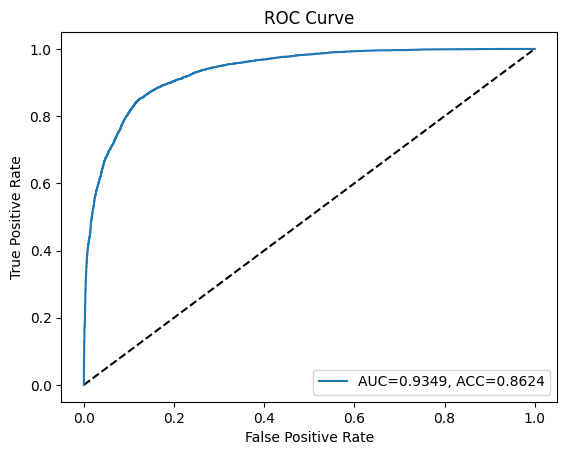

In [23]:
# Evaluate on validation data
val_pred_probs = model.predict(valid_flow, steps=num_valid)[:, 1]
val_true_labels = valid_flow.classes
val_pred_labels = (val_pred_probs > 0.5).astype(int)

val_accuracy = np.mean(val_pred_labels == val_true_labels)
fpr_vals, tpr_vals, _ = roc_curve(val_true_labels, val_pred_probs)
val_auc = auc(fpr_vals, tpr_vals)

print("\n--- Model Summary ---")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation AUC:      {val_auc:.4f}")
print(f"Training Time:       {train_duration:.2f} seconds")
print(f"Model Parameters:    {model.count_params():,}")

# ROC curve
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr_vals, tpr_vals, label=f"AUC={val_auc:.4f}, ACC={val_accuracy:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.savefig("roc_curve.png")
plt.show()


## Conclusion

The CNN model achieved a validation accuracy of 86.24% with an impressive AUC of 0.9349, indicating strong performance in distinguishing between cancerous and non-cancerous tissue images. However, while the training metrics improved over epochs, there is evidence of potential overfitting, as seen by the divergence between training and validation losses.

**Learnings & Takeaways:**
- The use of multiple convolutional blocks with batch normalization and dropout helped in feature extraction and regularization.
- Data augmentation significantly enriched the training data, but further experimentation with augmentation techniques may yield additional benefits.
- The callbacks for learning rate reduction and early stopping contributed to training stability.

**Future Improvements:**
- Experiment with deeper or alternative architectures (e.g., using residual connections) to further enhance feature extraction.
- Increase the aggressiveness of regularization methods to better control overfitting.
- Explore hyperparameter tuning over a broader range of learning rates, dropout rates, and batch sizes.
- Incorporate more advanced augmentation strategies or pre-trained networks to potentially boost the model's performance even further.

Overall, these insights lay a robust foundation for future refinements and improvements in tackling the complex task of histopathologic cancer detection.


In [30]:
# Load test images
test_path = "/kaggle/input/histopathologic-cancer-detection/test"
test_filenames = [fname for fname in os.listdir(test_path) if fname.endswith(".tif")]
test_frame = pd.DataFrame({"file_name": test_filenames})
test_count = len(test_frame)

# Load submission file
sub_file = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/sample_submission.csv")
sub_file["id"] = sub_file["id"].apply(lambda x: x + ".tif")

# Store all predictions from multiple runs
repeats = 10
for idx in range(repeats):
    test_gen = data_generator.flow_from_dataframe(
        dataframe=test_frame,
        directory=test_path,
        x_col="file_name",
        class_mode=None,
        target_size=image_dims[:2],
        batch_size=1,
        shuffle=False
    )

    current_preds = model.predict(test_gen, steps=test_count, verbose=1)[:, 1]
    pred_frame = pd.DataFrame({
        "id": test_gen.filenames,
        f"label{idx + 1}": current_preds
    })

    sub_file = sub_file.merge(pred_frame, on="id")

# Average the predictions
sub_file["label"] = sub_file[[f"label{i + 1}" for i in range(repeats)]].mean(axis=1)

# Clean up and export
sub_file.drop(columns=[f"label{i + 1}" for i in range(repeats)], inplace=True)
sub_file["id"] = sub_file["id"].apply(lambda x: x.split(".")[0])
sub_file.to_csv("submission.csv", index=False)


Found 57458 validated image filenames.
57458/57458 ━━━━━━━━━━━━━━━━━━━━ 470s 8ms/step
Found 57458 validated image filenames.
57458/57458 ━━━━━━━━━━━━━━━━━━━━ 178s 3ms/step
Found 57458 validated image filenames.
57458/57458 ━━━━━━━━━━━━━━━━━━━━ 155s 3ms/step
Found 57458 validated image filenames.
57458/57458 ━━━━━━━━━━━━━━━━━━━━ 149s 3ms/step
Found 57458 validated image filenames.
57458/57458 ━━━━━━━━━━━━━━━━━━━━ 149s 3ms/step
Found 57458 validated image filenames.
57458/57458 ━━━━━━━━━━━━━━━━━━━━ 148s 3ms/step
Found 57458 validated image filenames.
57458/57458 ━━━━━━━━━━━━━━━━━━━━ 148s 3ms/step
Found 57458 validated image filenames.
57458/57458 ━━━━━━━━━━━━━━━━━━━━ 148s 3ms/step
Found 57458 validated image filenames.
57458/57458 ━━━━━━━━━━━━━━━━━━━━ 149s 3ms/step
Found 57458 validated image filenames.
57458/57458 ━━━━━━━━━━━━━━━━━━━━ 147s 3ms/step
